In [3]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import PIL.Image
from torchvision.utils import make_grid
from utils import show

In [4]:
from data import RawWaterMeterDS
from utils import tuple_collate_fn, draw_bbox_with_tensor, object_detection_transform, TrainVisualizer
from models.SingleObjectDetectionNetwork import fasterrcnn_mobilenet_v3_large_320_fpn

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
dataset = RawWaterMeterDS('train', root='WaterMeterDataset/ProcessedData', target_transform=object_detection_transform)
train_ds, valid_ds = data.random_split(dataset, [0.8, 0.2])
dl = data.DataLoader(dataset, 6, shuffle=True, collate_fn=tuple_collate_fn)

In [10]:
model = fasterrcnn_mobilenet_v3_large_320_fpn()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
visualizer = TrainVisualizer()

In [11]:
num_epochs = 2
visualizer.reset()

mean_loss = 0
model.train()
for epoch in range(num_epochs):
    for idx, (X, y) in enumerate(dl):
        optimizer.zero_grad()
        X = list(X)
        for i in range(len(X)):
            X[i] = X[i].to(device)
        for j in range(len(y)):
            y[j]['boxes'] = y[j]['boxes'].to(device)
            y[j]['labels'] = y[j]['labels'].to(device)
        loss_dict = model(X, y)
        loss = sum(loss_dict.values())
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        mean_loss += loss.item()
        if (idx + 1) % 20 == 0:
            print(f'iters: {epoch * len(dl) + idx + 1} train_loss: {mean_loss / 20:.4f}')
            visualizer.record(**{
                'iterations': epoch * len(dl) + idx + 1,
                'loss_classifier': loss_dict['loss_classifier'].cpu().item(),
                'loss_box_reg': loss_dict['loss_box_reg'].cpu().item(),
                'loss_objectness': loss_dict['loss_objectness'].cpu().item(),
                'loss_rpn_box_reg': loss_dict['loss_rpn_box_reg'].cpu().item(),
                'sum_loss': mean_loss / 20
            })
            mean_loss = 0
visualizer.visualize('iterations', [['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'sum_loss']])

1.19632628262043
0.9538887679576874
0.8882974296808243
0.874047389626503
0.8461485207080841
0.8554799854755402
0.8508941054344177
0.8521553248167038
1.146819180250168
0.8244495749473572
0.8719319611787796
0.862861493229866
0.8337753355503082
0.8518125623464584
0.8482691913843154
0.858710914850235


KeyError: 'epoch'

In [18]:
# torch.save(model, '...')
# model = torch.load('TrainedModels/SODN.pt')

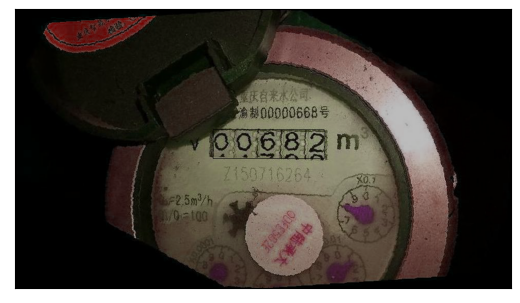

In [19]:
# show detection effects in test dataset
test_ds = RawWaterMeterDS('test', root='WaterMeterDataset/ProcessedData')
model.eval()
image_idx = 3
img = draw_bbox_with_tensor(test_ds[image_idx], model(test_ds[image_idx].unsqueeze(0).to(device))[0]['boxes'])
show(make_grid(img))

In [280]:
# seg patch in test images
with torch.no_grad():
    for idx in range(500):
        img = test_ds[idx]
        pred = model(img.unsqueeze(0).to(device))[0]['boxes'].to(torch.int)
        # check if bbox exists
        bbox = pred[0] if len(pred) != 0 else torch.tensor([0, 0, 100, 100])
        patch = img[:, bbox[1]: bbox[3], bbox[0]: bbox[2]]
        patch = transforms.ToPILImage()(patch)
        patch.save(f'WaterMeterDataset/ProcessedData/test_imgs_seg/test_seg_{idx + 1}.jpg')

In [ ]:
# seg patch in train images
for idx in range(1000):
    img = dataset[idx][0]
    bbox = dataset[idx][1]['boxes'][0]
    patch = img[:, max(bbox[1], torch.tensor([0])): bbox[3], max(bbox[0], torch.tensor([0])): bbox[2]]
    patch = transforms.ToPILImage()(patch)
    patch.save(f'WaterMeterDataset/ProcessedData/train_imgs_seg/train_seg_{idx + 1}.jpg')